In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from HodaDatasetReader import read_hoda_cdb, read_hoda_dataset
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
X_train, y_train = read_hoda_dataset(dataset_path='Train 60000.cdb',
                                images_height=32,
                                images_width=32,
                                one_hot=False,
                                reshape=True)
 
X_test, y_test = read_hoda_dataset(dataset_path='Test 20000.cdb',
                              images_height=32,
                              images_width=32,
                              one_hot=False,
                              reshape=True)

X_remaining, y_remaining = read_hoda_dataset(dataset_path='RemainingSamples.cdb',
                              images_height=32,
                              images_width=32,
                              one_hot=False,
                              reshape=True)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [ ]:
torch.manual_seed(42)

In [ ]:
X_train = X_train.reshape(60000,32,32)
X_test = X_test.reshape(20000,32,32)
X_train.shape
#X_test.shape
#X_train.shape

(60000, 32, 32)

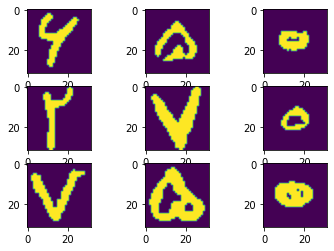

In [ ]:
import matplotlib.pyplot as plt
for i in range(9):	
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i])
plt.show()

In [ ]:
BATCH_SIZE = 256

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor) 

torch_X_train = torch_X_train.view(-1,1,32,32).float()
torch_X_train.shape

torch.Size([60000, 1, 32, 32])

In [ ]:
torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

torch_X_test = torch_X_test.view(-1,1,32,32).float()

In [ ]:
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

In [ ]:
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = Fulse)

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [ ]:
if torch.cuda.is_available():
    cnn = cnn.cuda()

In [ ]:
it = iter(train_loader)
X_batch, y_batch = next(it)
print(X_batch.shape)
print(y_batch.shape)

#if torch.cuda.is_available():
    #X_batch = X_batch.cuda()
    #y_batch = y_batch.cuda()
    
print(cnn.forward(X_batch).shape)

torch.Size([256, 1, 32, 32])
torch.Size([256])
torch.Size([256, 10])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
    if batch_idx == 0:
        print(data.shape)
        print(target.shape)

torch.Size([256, 1, 32, 32])
torch.Size([256])


In [ ]:
learning_rate = 0.01
momentum = 0.5
n_epochs = 15
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

scheduler = StepLR(optimizer,step_size=1 , gamma=0.9)
#optimizer = optim.SGD(cnn.parameters(), lr=learning_rate,momentum=momentum)

In [ ]:
train_losses = []
train_counter = []
test_losses = []

In [ ]:
def train(epoch):
    cnn.train()
    train_loss = 0
    scheduler.step()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        output = cnn(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 25 == 0: #every 25 * batchsize sample we print results
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
      
        train_loss += loss.item()

    train_losses.append(train_loss)
    train_counter.append(epoch)

    torch.save(cnn.state_dict(), 'model.pth')
    torch.save(cnn.state_dict(), 'optimizer.pth')

In [ ]:
def test():
  cnn.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        output = cnn(data)
        test_loss += F.nll_loss(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.037512
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.169066
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.221198
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.078384
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.131505
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.139803
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.148466
Train Epoch: 1 [44800/60000 (74%)]	Loss: 0.165092
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.147568
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.062715


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0820, Accuracy: 19460/20000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.082326
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.075071
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.061890
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.102009
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.098965
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.058255
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.152646
Train Epoch: 2 [44800/60000 (74%)]	Loss: 0.082218
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.100554
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.094894

Test set: Avg. loss: 0.0704, Accuracy: 19572/20000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.078988
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.125634
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.089002
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.059983
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.110667
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.087427
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.081967
Train Epoch: 3 [44800/60000 (74%)]	Loss: 0.1